  # Introduction

## Prediction question that can be answered with data and a machine learning model: 
### Can we guess what position a player is in baseball using how he did in that season?

# Motivation Behind Project
### The reason that I wanted to do this project is becasue I grew up a huge fan of baseball and our family are big fans of baseball. I wanted to use all of the many statistics that happens in baseball to try and predict and in this case I wanted to see if it could predict something like a player's position. I feel like this is a hard task since each position doesn't seem better than another.

## Contents of Project:
- ### Data Collection
- ### Data Cleaning & EDA
- ### Modeling
- ### Conclusions & Limitations

### Read in Packages

In [28]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import plotly.express as px
import seaborn as sns

 # Data
# Collection of the data 
### In the next two cells, I webscraped the MLB's website and used a loop to webscrape the data for each year since 1990. Each year would have multiple pages attached. Overall I did it with 30 years and almost each year had about 6 pages of data to webscrape, so I am scraping data from about 180 different webpages.

In [2]:
page1 = pd.read_html("https://www.mlb.com/stats/regular-season")
url = "https://www.mlb.com/stats/regular-season?page=2"
mlb = pd.DataFrame()
while len(pd.read_html(url)[0])>0:
    mlb = pd.concat([mlb, pd.read_html(url)[0]])
    num = int(url[-1])
    num +=1
    url = url.replace(url[-1],str(num))
mlb = pd.concat([page1[0], mlb])
mlb["Year"] = 2020

PLAYER TEAM   G   AB   R   H  2B  3B  HR  RBI  \
0                1JuanJ SotoSotoLF1‌‌‌  WSH  47  154  39  54  14   0  13   37   
1       2FreddieF FreemanFreeman1B2‌‌‌  ATL  60  214  51  73  23   1  13   53   
2           3MarcellM OzunaOzunaDH3‌‌‌  ATL  60  228  38  77  14   0  18   56   
3          4DJD LeMahieuLeMahieu2B4‌‌‌  NYY  50  195  41  71  10   2  10   27   
4          5JoseJ RamírezRamirez3B5‌‌‌  CLE  58  219  45  64  16   1  17   46   
..                                 ...  ...  ..  ...  ..  ..  ..  ..  ..  ...   
12  138EduardoE EscobarEscobar3B138‌‌‌  ARI  54  203  22  43   7   3   4   20   
13         139JavierJ BáezBaezSS139‌‌‌  CHC  59  222  27  45   9   1   8   24   
14         140EvanE WhiteWhite1B140‌‌‌  SEA  54  182  19  32   7   0   8   26   
15   141JonathanJ VillarVillar2B141‌‌‌  TOR  52  185  13  43   5   0   2   15   
16        142NickyN LopezLopez2B142‌‌‌   KC  56  169  15  34   8   0   1   13   

    BB  SO  SB  CS    AVG    OBP    SLG  caret-upcaret-downOPS  Year  
0   41  28   6   2  0.351  0.490  0.695                  1.185  2020  
1   45  37   2   0  0.341  0.462  0.640                  1.102  2020  
2   38  60   0   0  0.338  0.431  0.636                  1.067  2020  
3   18  21   3   0  0.364  0.421  0.590                  1.011  2020  
4   31  43  10   3  0.292  0.386  0.607                  0.993  2020  
..  ..  ..  ..  ..    ...    ...    ...                    ...   ...  
12  15  41   1   0  0.212  0.270  0.335                  0.605  2020  
13   7  75   3   0  0.203  0.238  0.360                  0.599  2020  
14  18  84   1   2  0.176  0.252  0.346                  0.599  2020  
15  19  54  16   5  0.232  0.301  0.292                  0.593  2020  
16  18  41   0   5  0.201  0.286  0.266                  0.552  2020  

[142 rows x 19 columns]

In [3]:
"https://www.mlb.com/stats/2019/regular-season"

years = np.arange(1990,2020)

for year in years:
    page1 = pd.read_html("https://www.mlb.com/stats/"+str(year)+"/regular-season")
    page1 = page1[0]
    page1["Year"] = year
    url = "https://www.mlb.com/stats/"+str(year)+"?page=2"
    test = pd.DataFrame()
    while len(pd.read_html(url)[0])>0:
        test = pd.concat([test, pd.read_html(url)[0]])
        num = int(url[-1])
        num +=1
        url = url.replace(url[-1],str(num))
    test["Year"] = year
    test = pd.concat([page1,test])
    mlb = pd.concat([mlb,test])
    

# Cleaning the Data
### In order to clean the data, I needed to clean up the names of the players by taking out the numbers that were attached. I also cleaned up my data by grabbing the position of the player. The position was located in the player column right after their name. This will by my Y column or the column that I am trying to predict.

In [125]:
player = []
for person in mlb["PLAYER"]:
    pattern = '(?<=[\d+])\D+(?=(?:[\d+]))'
    player.append(re.findall(pattern,person)[0])
    
mlb['PLAYER_updated'] = player

In [126]:
position = []
for person in mlb["PLAYER"]:
    pattern = '(?<=[a-z\.])[A-Z1-9][A-Z]|C(?=\d+)'
    position.append(re.findall(pattern,person)[0])
    
mlb['PLAYER_position'] = position

In [113]:
mlb.rename(columns = {"caret-upcaret-downOPS":"OPS"}, inplace = True)

In [128]:
mlb.head()

PLAYER TEAM   G   AB   R   H  2B  3B  HR  RBI  ...  \
0           1JuanJ SotoSotoLF1‌‌‌  WSH  47  154  39  54  14   0  13   37  ...   
1  2FreddieF FreemanFreeman1B2‌‌‌  ATL  60  214  51  73  23   1  13   53  ...   
2      3MarcellM OzunaOzunaDH3‌‌‌  ATL  60  228  38  77  14   0  18   56  ...   
3     4DJD LeMahieuLeMahieu2B4‌‌‌  NYY  50  195  41  71  10   2  10   27  ...   
4     5JoseJ RamírezRamirez3B5‌‌‌  CLE  58  219  45  64  16   1  17   46  ...   

   SO  SB  CS    AVG    OBP    SLG    OPS  Year           PLAYER_updated  \
0  28   6   2  0.351  0.490  0.695  1.185  2020         JuanJ SotoSotoLF   
1  37   2   0  0.341  0.462  0.640  1.102  2020  FreddieF FreemanFreeman   
2  60   0   0  0.338  0.431  0.636  1.067  2020    MarcellM OzunaOzunaDH   
3  21   3   0  0.364  0.421  0.590  1.011  2020     DJD LeMahieuLeMahieu   
4  43  10   3  0.292  0.386  0.607  0.993  2020     JoseJ RamírezRamirez   

  PLAYER_position  
0              LF  
1              1B  
2              DH  
3              2B  
4              3B  

[5 rows x 21 columns]

# Feature Creation
### I didn't create any features, because based on the data that I have I didn't think there was a baseball statistic that I could make up.

# EDA
#### I wanted to understand the spread of my data more, especially with the differences between the different positions to get an idea of any differences.

In [78]:
mlb["PLAYER_position"].value_counts()

1B    725
3B    643
2B    527
SS    524
CF    487
LF    486
RF    459
DH    245
OF    171
C     169
Name: PLAYER_position, dtype: int64

In [9]:
mlb["Year"].value_counts()

1998    159
1999    157
2017    150
1992    147
1993    147
1996    147
1995    147
1994    147
1997    144
2001    142
2016    142
2020    142
2009    142
2012    142
2008    142
2004    142
2000    142
2005    142
2019    142
2013    142
2015    142
2002    142
2006    142
2010    142
2014    142
2018    142
2003    142
2007    142
2011    142
1990    128
1991    123
Name: Year, dtype: int64

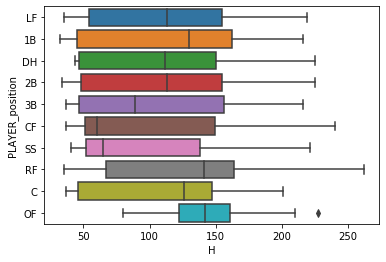

In [129]:
sns.boxplot(data = mlb, x = "H", y = "PLAYER_position")

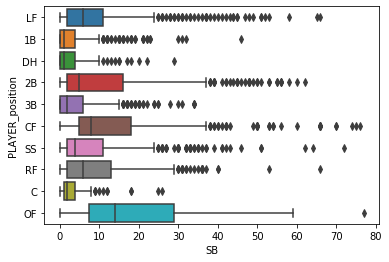

In [130]:
sns.boxplot(data = mlb, x = "SB", y = "PLAYER_position")

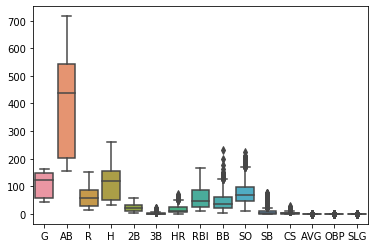

In [131]:
sns.boxplot(data = mlb.iloc[:,2:-4])

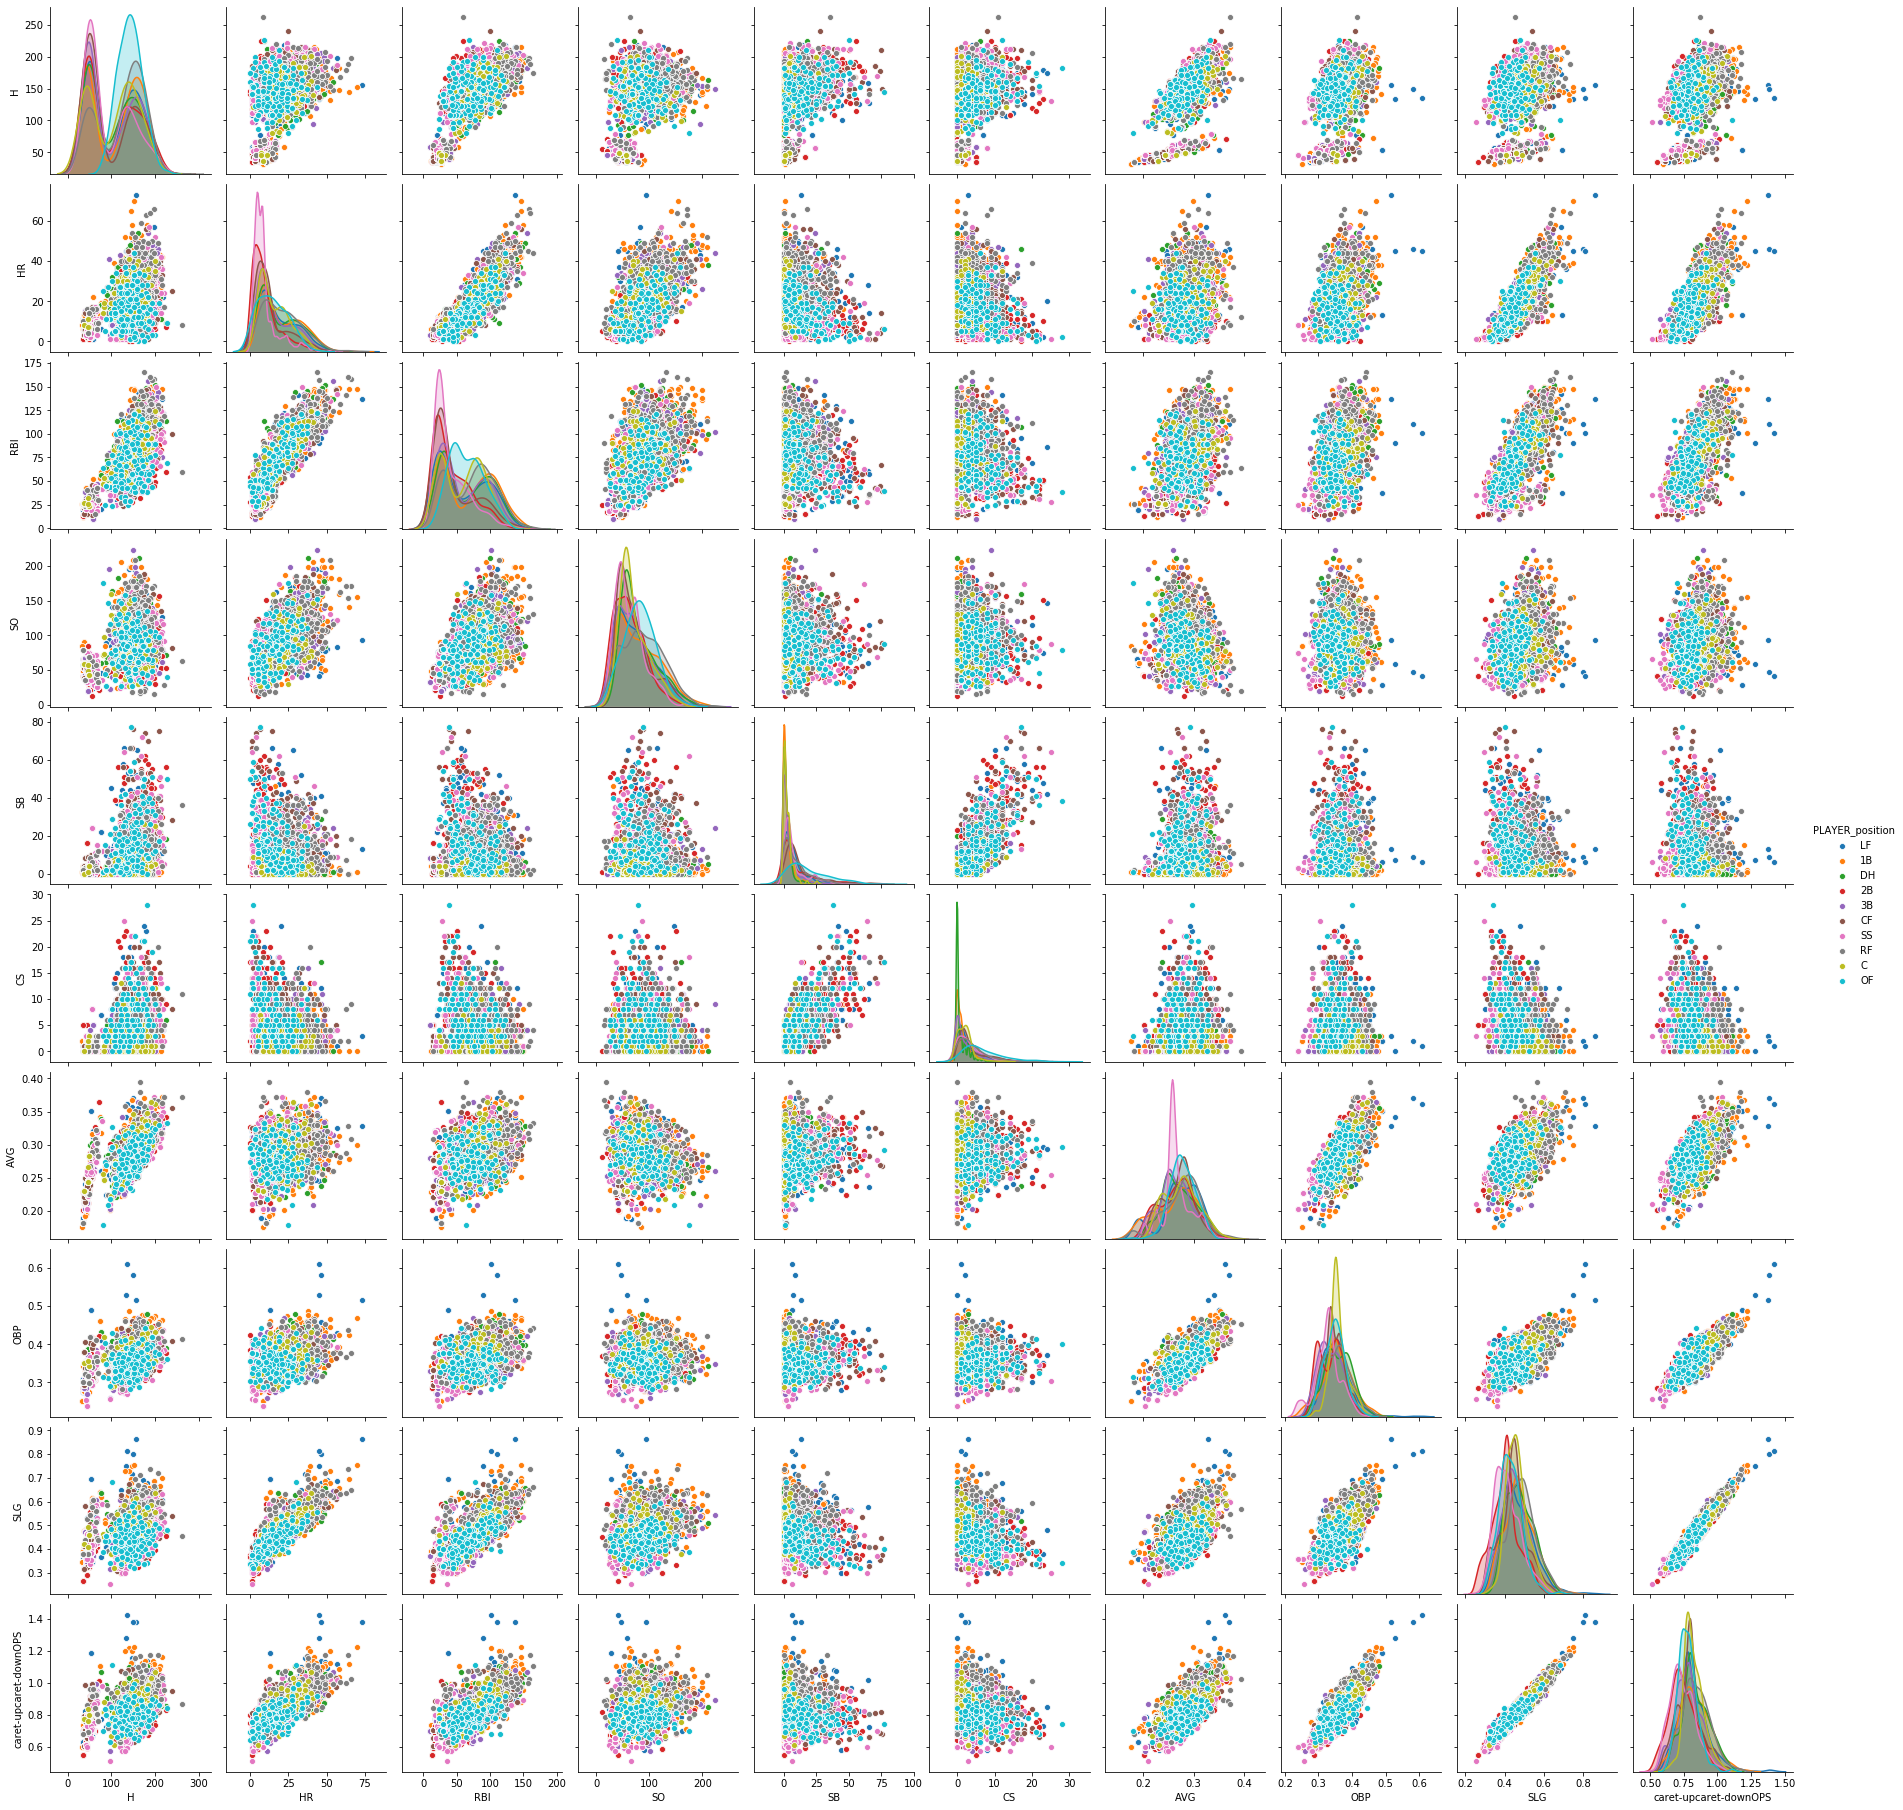

In [15]:
sns.pairplot(mlb[['H', 'HR', 'RBI','SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'caret-upcaret-downOPS', "PLAYER_position"]], hue = "PLAYER_position")

 # Methods and Results

## Analyze Data Through Machine Learning Approaches (Modeling)

### I prepared to analyze the data through machine learning by first changing the positions to be numbers instead of position names.
### Then I identified which columns were going to be my X variables. Using that information I split my data into train and test dataframes. I made sure to startify by player position so that I can have the same percentage of each position in the test as it is in the train

In [117]:
#Creating the dependent variable class
factor = pd.factorize(mlb['PLAYER_position'])
mlb.PLAYER_position = factor[0]
definitions = factor[1]
print(mlb.PLAYER_position.head())
print(definitions)

0    0
1    1
2    2
3    3
4    4
Name: PLAYER_position, dtype: int64
Index(['LF', '1B', 'DH', '2B', '3B', 'CF', 'SS', 'RF', 'C', 'OF'], dtype='object')


In [118]:
#Splitting the data into independent and dependent variables
X = mlb.iloc[:,2:-2]
y = mlb.iloc[:,-1]
X["Year"] = pd.Categorical(X.Year)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21, stratify = mlb.PLAYER_position)

### I then made sure to scale each X variable

In [120]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Machine Learning Models Used:
### From here I am trying all sorts of models and seeing which one fits best. I also hypertune a few of the models. I tried KNN, Decision Tree, Random Forest, Gradient Boost, Logisitic Regression, LinearSVC, and Gaussian Bayes. I am using each of these models because they are good models (or can be adapted) to use for multivariate multi- class problems like this one.
# Evaluate each model. 


### First I tried KNN Classifier. This next cell is mostly commented out because it takes awhile to run. I have already run it so I am using the best parameters I found after hypertuning it when fitting my model.

In [83]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
#hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
#knn_2 = KNeighborsClassifier()
#Use GridSearch
#clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
#best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 2
Best n_neighbors: 1


In [84]:
knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 1, p = 2)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Model Evaluation Metrics
### Here I was printing the classification report which is what I used to evaluate my models. Specifially, we were looking at the accuracy of the model which shows how well the model did in accurately guessing a position of a player overall. For KNN you will see that the accuracy is 65%

In [85]:
yhat_knn = knn.predict(X_test)
confusion_matrix(y_test, yhat_knn)
print(classification_report(y_test, yhat_knn))
#print(roc_auc_score(y_test.reset_index(drop = True), yhat_knn, multi_class = 'ovr'))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       121
           1       0.69      0.69      0.69       181
           2       0.44      0.49      0.47        61
           3       0.71      0.70      0.71       132
           4       0.66      0.65      0.66       161
           5       0.74      0.80      0.77       122
           6       0.82      0.76      0.79       131
           7       0.48      0.51      0.50       115
           8       0.52      0.55      0.53        42
           9       0.59      0.47      0.52        43

    accuracy                           0.65      1109
   macro avg       0.63      0.62      0.63      1109
weighted avg       0.66      0.65      0.66      1109



### Decision Tree is the next one I tried. In the next two cells I was hypertuning my model so that I can find the best parameters. It also takes awhile so a lot of is commented out and the best parameters for my model is shown below.

In [86]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

splitter = ['best','random']
max_features = ["auto", "sqrt", "log2"]

In [87]:
#dt_pipe = Pipeline(
#    [('dt', DecisionTreeClassifier())])
#param_grid = [{'dt__max_features':max_features,
#              'dt__max_depth':max_depth,
#              'dt__min_samples_split':min_samples_split,
#              'dt__min_samples_leaf':min_samples_leaf,
#              'dt__splitter':splitter}]
#gs = GridSearchCV(dt_pipe, param_grid)
#gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                       

In [88]:
gs.best_params_

{'dt__max_depth': 110,
 'dt__max_features': 'log2',
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__splitter': 'best'}

### After fitting my Decision Tree model I got an accuracy of 63%

In [89]:
dt = DecisionTreeClassifier(max_depth = 110, max_features = 'log2', min_samples_leaf = 1, min_samples_split = 2, splitter = 'best')
dt.fit(X_train, y_train)
yhat_dt = dt.predict(X_test)
print(classification_report(y_test, yhat_dt))

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       121
           1       0.61      0.60      0.60       181
           2       0.56      0.52      0.54        61
           3       0.68      0.70      0.69       132
           4       0.62      0.64      0.63       161
           5       0.73      0.78      0.75       122
           6       0.77      0.75      0.76       131
           7       0.50      0.50      0.50       115
           8       0.65      0.57      0.61        42
           9       0.52      0.53      0.53        43

    accuracy                           0.63      1109
   macro avg       0.62      0.61      0.62      1109
weighted avg       0.63      0.63      0.63      1109



### The next one I tried was the Gradient Boost Model and after fitting it with the default parameters, I found that the accuracy was 23% which is very low and not worth doing any tuning with.

In [45]:
ac = AdaBoostClassifier()
ac.fit(X_train, y_train)
yhat_ac = ac.predict(X_test)
print(classification_report(y_test, yhat_ac))

              precision    recall  f1-score   support

           0       0.08      0.04      0.05       121
           1       0.36      0.43      0.39       181
           2       0.06      0.03      0.04        61
           3       0.14      0.27      0.18       132
           4       0.40      0.16      0.22       161
           5       0.25      0.32      0.28       122
           6       0.23      0.40      0.29       131
           7       0.36      0.07      0.12       115
           8       0.07      0.05      0.06        42
           9       0.28      0.30      0.29        43

    accuracy                           0.23      1109
   macro avg       0.22      0.21      0.19      1109
weighted avg       0.25      0.23      0.22      1109



### The next one I tried was a Logistic Regression Model that was specifically for a multi-class classification. I found that this one had a low accuracy as well because it was 28%. It seems that the next few models weren't as good with multi-class classification as KNN, Decision Trees, and Random Forests.

In [46]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(multi_class = 'ovr', solver = 'newton-cg')
lr.fit(X_train, y_train)
yhat_lr = lr.predict(X_test)
print(classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

           0       0.25      0.12      0.17       121
           1       0.29      0.68      0.40       181
           2       0.00      0.00      0.00        61
           3       0.37      0.45      0.41       132
           4       0.11      0.07      0.08       161
           5       0.28      0.32      0.30       122
           6       0.28      0.40      0.33       131
           7       0.00      0.00      0.00       115
           8       0.00      0.00      0.00        42
           9       0.29      0.23      0.26        43

    accuracy                           0.28      1109
   macro avg       0.19      0.23      0.19      1109
weighted avg       0.21      0.28      0.23      1109



C:\Users\bradi\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### The next model that I tried was the Gaussian Naive Bayes model. Once I fit the model, I also found that this one had a low accuracy of 26%

In [47]:
from sklearn.naive_bayes import GaussianNB
gb = GaussianNB()
gb.fit(X_train, y_train)
yhat_gb = gb.predict(X_test)
print(classification_report(y_test, yhat_gb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.31      0.26      0.28       181
           2       0.00      0.00      0.00        61
           3       0.42      0.04      0.07       132
           4       0.22      0.16      0.19       161
           5       1.00      0.02      0.03       122
           6       0.16      0.51      0.25       131
           7       0.19      0.30      0.23       115
           8       0.17      0.17      0.17        42
           9       0.16      0.70      0.26        43

    accuracy                           0.20      1109
   macro avg       0.26      0.21      0.15      1109
weighted avg       0.29      0.20      0.16      1109



### The next model that I tried was the LinearSVC model. Once I fit the model, I also found that this one had a low accuracy of 29%

In [50]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
yhat_lsvc = lsvc.predict(X_test)
print(classification_report(y_test, yhat_lsvc))

              precision    recall  f1-score   support

           0       0.33      0.05      0.09       121
           1       0.28      0.62      0.39       181
           2       1.00      0.02      0.03        61
           3       0.37      0.45      0.41       132
           4       0.26      0.24      0.25       161
           5       0.27      0.33      0.30       122
           6       0.30      0.38      0.34       131
           7       0.22      0.07      0.11       115
           8       0.00      0.00      0.00        42
           9       0.25      0.19      0.21        43

    accuracy                           0.29      1109
   macro avg       0.33      0.23      0.21      1109
weighted avg       0.32      0.29      0.25      1109



C:\Users\bradi\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



# Improving Model Performance (Hypertuning)
### Random Forest is the next one I tried and it is the one I chose to use. In the next two cells I was hypertuning my model so that I can find the best parameters. It also takes awhile so a lot of is commented out and the best parameters for my model is shown below. The only one I do differently is the n_estimators parameter because it is best to have more, so when I ran the model, I instead had n_estimators=2000



In [92]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]

n_estimators = 100
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [93]:
#rf_pipe = Pipeline(
#    [('rf', RandomForestClassifier())])
#param_grid = [{'rf__n_estimators': [100],
#              'rf__max_features':max_features,
#              'rf__max_depth':max_depth,
#              'rf__min_samples_split':min_samples_split,
#              'rf__min_samples_leaf':min_samples_leaf,
#              'rf__bootstrap':bootstrap}]
#gs = GridSearchCV(rf_pipe, param_grid)
#gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                            

In [94]:
gs.best_params_

{'rf__bootstrap': True,
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 100}

In [121]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(n_estimators = 2000, random_state = 42, max_features = 'sqrt', max_depth = None, min_samples_leaf = 1, min_samples_split = 5, bootstrap = True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Summary of Model Performance
### After hypertuning my Random Forest model, I found that my accuracy was 67% as you will see below. I ended up using the Random Forest model because it has the highest accuracy out of all my models.

In [122]:
yhat_rf = rf.predict(X_test)
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       121
           1       0.54      0.82      0.65       181
           2       0.84      0.44      0.58        61
           3       0.71      0.73      0.72       132
           4       0.69      0.64      0.66       161
           5       0.77      0.78      0.77       122
           6       0.90      0.79      0.84       131
           7       0.53      0.54      0.53       115
           8       0.78      0.50      0.61        42
           9       0.69      0.51      0.59        43

    accuracy                           0.67      1109
   macro avg       0.71      0.63      0.66      1109
weighted avg       0.69      0.67      0.67      1109



In [123]:
print(list(zip(X.columns, rf.feature_importances_)))


[('G', 0.05235325819816901), ('AB', 0.0658926170509164), ('R', 0.06622426093059423), ('H', 0.06454216516177125), ('2B', 0.0671997257697289), ('3B', 0.03319643244022238), ('HR', 0.05657905539994003), ('RBI', 0.070128662831007), ('BB', 0.07477486202229232), ('SO', 0.05717661983096324), ('SB', 0.07103919916015343), ('CS', 0.04609247661757426), ('AVG', 0.06347936059417883), ('OBP', 0.06138974439080133), ('SLG', 0.06131233069858626), ('OPS', 0.058405492986700516), ('Year', 0.030213735916400655)]


### Below shows the importance of each X variable in predicting the position of the player. It looks like how many walks, stolen bases, and RBI's a player had were the most important X variables in knowing what position each of them were.

In [124]:
test = pd.DataFrame(X.columns, rf.feature_importances_).reset_index()
test.columns = ["Importance","Stat"]
test.sort_values(by = "Importance", ascending = False)

Importance  Stat
8     0.074775    BB
10    0.071039    SB
7     0.070129   RBI
4     0.067200    2B
2     0.066224     R
1     0.065893    AB
3     0.064542     H
12    0.063479   AVG
13    0.061390   OBP
14    0.061312   SLG
15    0.058405   OPS
9     0.057177    SO
6     0.056579    HR
0     0.052353     G
11    0.046092    CS
5     0.033196    3B
16    0.030214  Year

# Strengths of Random Forest
### 1. Uses Ensemble Learning techniques
### 2. Creates many trees and summarizes over all of them and so is more accurate than Decision Trees.
### 3. Can handle missing values
### 4. Not affected very much by outliers
# Weaknesses of Random Forest
### 1. Requires more computational power than Decision Trees or other models

 # Conclusion
## The answer to the question is that yes, we can predict a player's position based on his statistics. We can predict the player's position with an accuracy of 67%. That is pretty good given the fact that there are 10 positions that it is guessing between.

 # Methods and Results Part 2 (less player positions)
### For this next part of my code, I wanted to see how my models would do if I changed it from 10 positions to 3. I am now making all of the infielders to have the position title of IF and the outfielders to be OF, and then keeping the original DH. So now I will repeat the last steps where I will do a little EDA and then trying multiple models until I find the best one. From there I will hypertune that model and report my findings.

In [97]:
position = []
for person in mlb["PLAYER"]:
    pattern = '(?<=[a-z\.])[A-Z1-9][A-Z]|C(?=\d+)'
    position.append(re.findall(pattern,person)[0])
    
mlb['PLAYER_position'] = position

In [98]:
OF = ["LF","RF","CF","OF"]
IF = ["1B","2B","3B","SS","C"]
position = []
for player in mlb["PLAYER_position"]:
    if player in OF:
        position.append("OF")
    elif player in IF:
        position.append("IF")
    else:
        position.append("DH")
mlb["PLAYER_position"] = position

In [99]:
#Creating the dependent variable class
factor = pd.factorize(mlb['PLAYER_position'])
mlb.PLAYER_position = factor[0]
definitions = factor[1]
print(mlb.PLAYER_position.head())
print(definitions)

0    0
1    1
2    2
3    1
4    1
Name: PLAYER_position, dtype: int64
Index(['OF', 'IF', 'DH'], dtype='object')


#  EDA (Repeated)

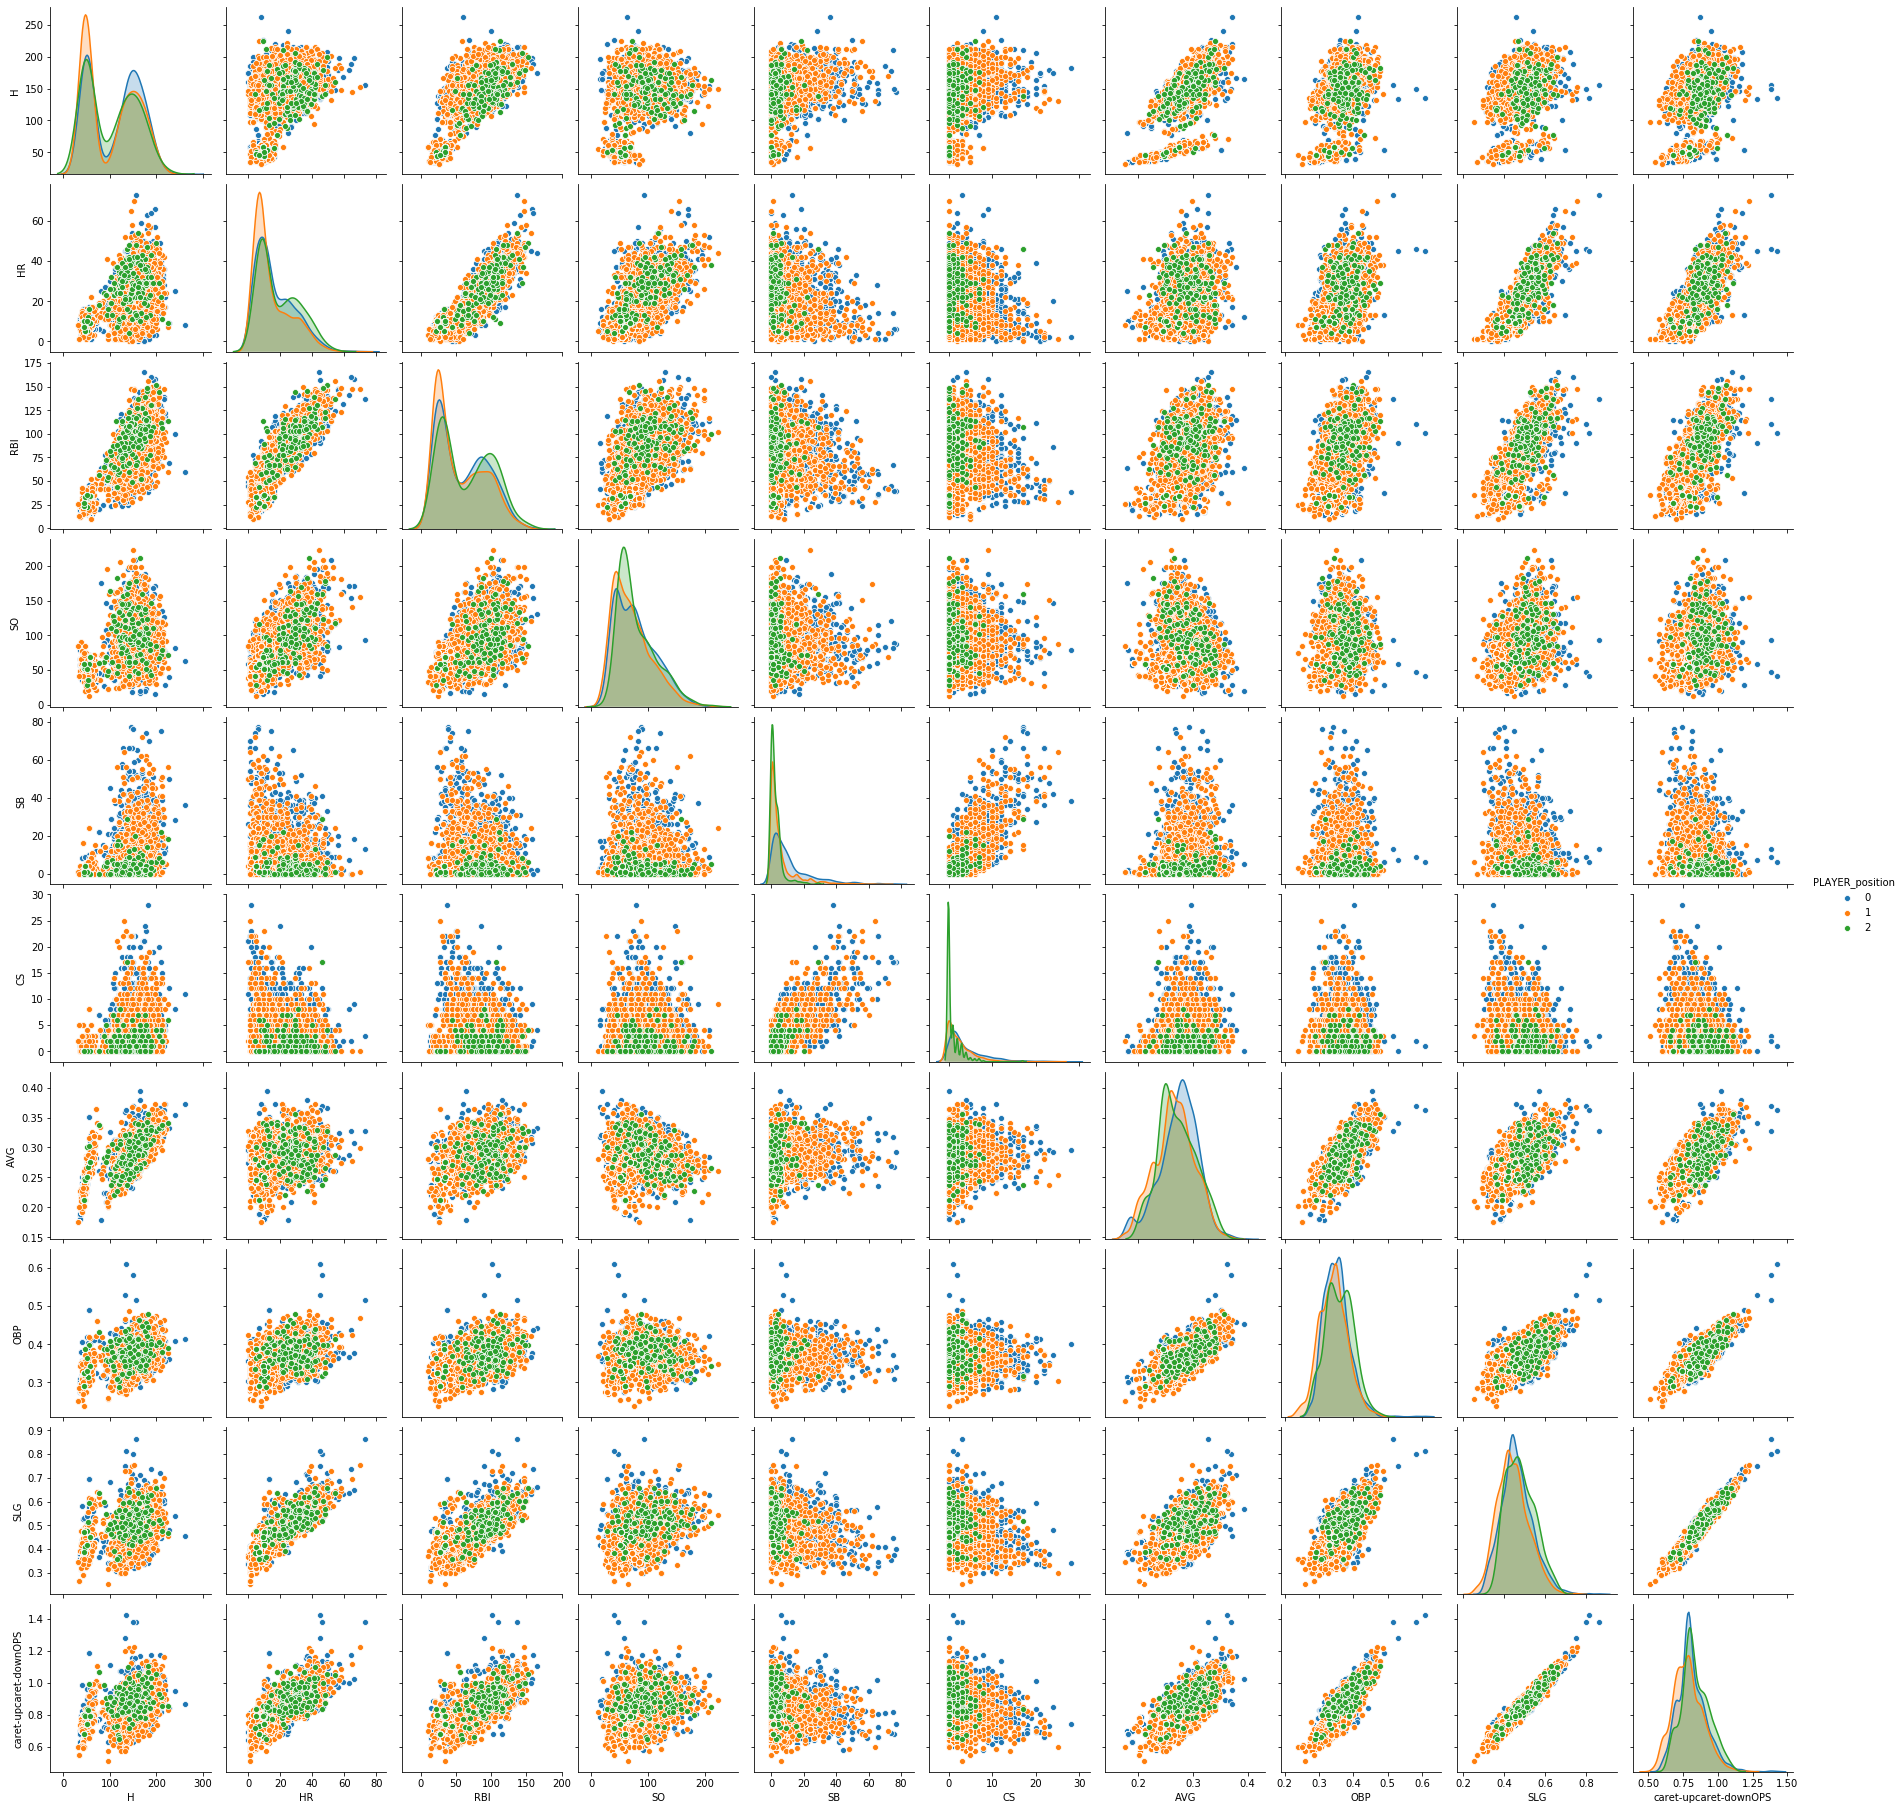

In [58]:
sns.pairplot(mlb[['H', 'HR', 'RBI','SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'caret-upcaret-downOPS', "PLAYER_position"]], hue = "PLAYER_position")

## Here I am creating my X and Y variables again. I am also splitting up the data into training and testing datasets. I then scale my data.

In [100]:
#Splitting the data into independent and dependent variables
X = mlb.iloc[:,2:-2]
y = mlb.iloc[:,-1]
X["Year"] = pd.Categorical(X.Year)

In [101]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.25, random_state = 21, stratify = mlb.PLAYER_position)

In [102]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

# Model Fitting (Repeated)

### In these models, I did less hypertuning. I did all the default parameters until I have chosen the model that I want to do. Then I did some hypertuning on that model.

### First I tried KNN Classifier and found it to have a 78% accuracy.

In [63]:
knn = KNeighborsClassifier()
knn.fit(X_train2,y_train2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [64]:
yhat_knn = knn.predict(X_test2)
confusion_matrix(y_test2, yhat_knn)
print(classification_report(y_test2, yhat_knn))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       401
           1       0.81      0.84      0.83       647
           2       0.87      0.43      0.57        61

    accuracy                           0.78      1109
   macro avg       0.80      0.67      0.71      1109
weighted avg       0.79      0.78      0.78      1109



### I then did the Gradient Boost Model and found the accuracy to be 65%

In [65]:
ac = AdaBoostClassifier()
ac.fit(X_train2, y_train2)
yhat_ac = ac.predict(X_test2)
print(classification_report(y_test2, yhat_ac))

              precision    recall  f1-score   support

           0       0.60      0.47      0.53       401
           1       0.67      0.80      0.73       647
           2       0.67      0.23      0.34        61

    accuracy                           0.65      1109
   macro avg       0.65      0.50      0.53      1109
weighted avg       0.65      0.65      0.64      1109



### Then I did Logistic Regression and found the accuracy to be 64%

In [66]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(multi_class = 'ovr', solver = 'newton-cg')
lr.fit(X_train2, y_train2)
yhat_lr = lr.predict(X_test2)
print(classification_report(y_test2, yhat_lr))

              precision    recall  f1-score   support

           0       0.61      0.36      0.46       401
           1       0.65      0.87      0.74       647
           2       0.00      0.00      0.00        61

    accuracy                           0.64      1109
   macro avg       0.42      0.41      0.40      1109
weighted avg       0.60      0.64      0.60      1109



C:\Users\bradi\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Then I did Gaussian Naive Bayes Model and found the accuracy to be 55%

In [67]:
from sklearn.naive_bayes import GaussianNB
gb = GaussianNB()
gb.fit(X_train2, y_train2)
yhat_gb = gb.predict(X_test2)
print(classification_report(y_test2, yhat_gb))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49       401
           1       0.66      0.61      0.63       647
           2       0.21      0.44      0.29        61

    accuracy                           0.55      1109
   macro avg       0.46      0.51      0.47      1109
weighted avg       0.58      0.55      0.56      1109



### Then I tried LInearSVC model and found the accuracy to be 64%

In [68]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train2, y_train2)
yhat_lsvc = lsvc.predict(X_test2)
print(classification_report(y_test2, yhat_lsvc))   

              precision    recall  f1-score   support

           0       0.61      0.34      0.44       401
           1       0.64      0.88      0.74       647
           2       0.00      0.00      0.00        61

    accuracy                           0.64      1109
   macro avg       0.42      0.41      0.39      1109
weighted avg       0.59      0.64      0.59      1109



C:\Users\bradi\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\bradi\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Finally, I did Random Forest. This is the one that I ended up choosing. So, I made sure to do some hypertuning as you will see in the next couple of cells that is now commented out. Using that information I fit my model and found that I got an accuracy of 82%

In [103]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]

n_estimators = 100
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [104]:
rf_pipe = Pipeline(
    [('rf', RandomForestClassifier())])
param_grid = [{'rf__n_estimators': [100],
              'rf__max_features':max_features,
              'rf__max_depth':max_depth,
              'rf__min_samples_split':min_samples_split,
              'rf__min_samples_leaf':min_samples_leaf,
              'rf__bootstrap':bootstrap}]
gs = GridSearchCV(rf_pipe, param_grid)
gs.fit(X_train2, y_train2)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                            

In [105]:
gs.best_params_

{'rf__bootstrap': True,
 'rf__max_depth': 80,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100}

In [106]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(n_estimators = 2000, max_depth = 70, min_samples_leaf = 2, min_samples_split = 5)
rf.fit(X_train2, y_train2)
yhat_rf = rf.predict(X_test2)
print(classification_report(y_test2, yhat_rf))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79       401
           1       0.82      0.88      0.85       647
           2       1.00      0.41      0.58        61

    accuracy                           0.82      1109
   macro avg       0.87      0.69      0.74      1109
weighted avg       0.82      0.82      0.81      1109



In [107]:
# Predicting the Test set results
y_pred = rf.predict(X_test2)
reversefactor = dict(zip(range(10),definitions))
y_test_vector = np.vectorize(reversefactor.get)(y_test2)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test_vector, y_pred, rownames=['Actual Positions'], colnames=['Predicted Positions']))

Predicted Positions  DH   IF   OF
Actual Positions                 
DH                   25   35    1
IF                    0  572   75
OF                    0   91  310


In [108]:
print(list(zip(X.columns, rf.feature_importances_)))


[('G', 0.05029365427106345), ('AB', 0.06542199021647603), ('R', 0.06268407407345901), ('H', 0.0630785214902555), ('2B', 0.06317278973533337), ('3B', 0.0290711279152675), ('HR', 0.048034938946432085), ('RBI', 0.058969208931903605), ('BB', 0.05639411441956343), ('SO', 0.05913245011244765), ('SB', 0.10216575867720597), ('CS', 0.0630829755461549), ('AVG', 0.059644232800475344), ('OBP', 0.0626950941036425), ('SLG', 0.0637722612263043), ('caret-upcaret-downOPS', 0.06761729819622511), ('Year', 0.02476950933779025)]


### Here is a dataframe that shows the most important features in my Random Forest model in predicting the position of the baseball player. It looks like the most important features is stolen bases, OPS, and At-Bat's

In [109]:
test = pd.DataFrame(X.columns, rf.feature_importances_).reset_index()
test.columns = ["Importance","Stat"]
test.sort_values(by = "Importance", ascending = False)

Importance                   Stat
10    0.102166                     SB
15    0.067617  caret-upcaret-downOPS
1     0.065422                     AB
14    0.063772                    SLG
4     0.063173                     2B
11    0.063083                     CS
3     0.063079                      H
13    0.062695                    OBP
2     0.062684                      R
12    0.059644                    AVG
9     0.059132                     SO
7     0.058969                    RBI
8     0.056394                     BB
0     0.050294                      G
6     0.048035                     HR
5     0.029071                     3B
16    0.024770                   Year

 # Conclusion (Repeated)
## The answer to the question is again yes, we can predict a player's position based on his statistics from their season. We can predict the player's position with an accuracy of 83%. That is pretty accurate model.

# Potential Sources of Bias

### There definitely can be some bias in my data or models. I think that there is more information or statistics that we can get. I had a hard time finding the salary of each of these players in the year that they played. I felt like that could be another important feature to include. There are also lots of different baseball statistics that we can get. However, I couldn't figure out how to scrape it, so we were left with the 15 or so columns that I had.

### Another potential source of bias is how one player could show up multiple times in the dataset. So there could be some collinearity because of similar players.

### I feel like my new question that I would like to answer is if we can again predict the player's position if we have more data that we couldn't get from this project.